In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

In [2]:
# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

#regression
from sklearn.linear_model import LinearRegression,Ridge,LassoCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sample = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

In [6]:
#Drop the id column

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

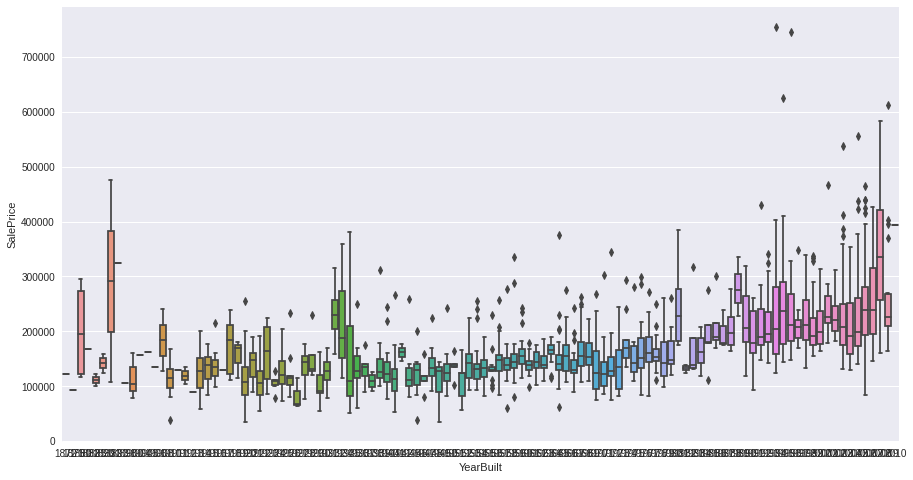

In [7]:
# It seems that the price of recent-built houses are higher

plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

# From the graph we can surely see plenty of outliers.

(0.0, 800000.0)

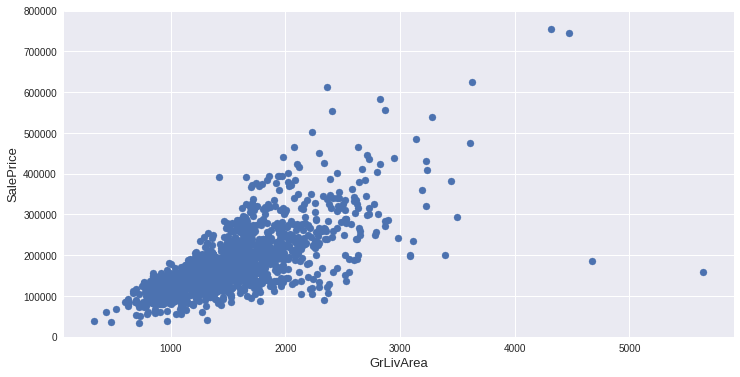

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

(0.0, 800000.0)

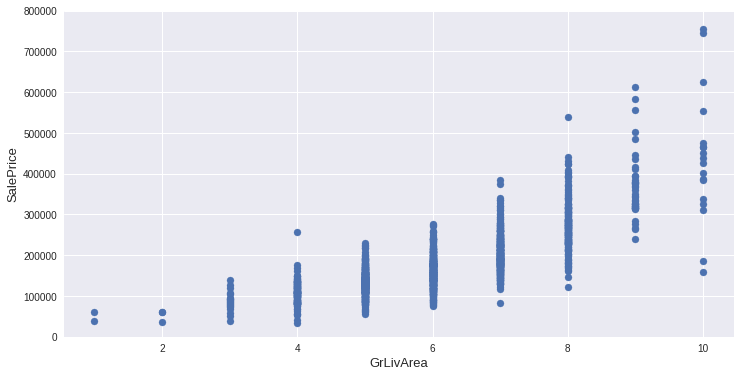

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.OverallQual, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

As Suggested by many participants in Kaggle that the outliers shall be removed

In [10]:
train.drop(train[(train['GrLivArea']>=4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

(0.0, 800000.0)

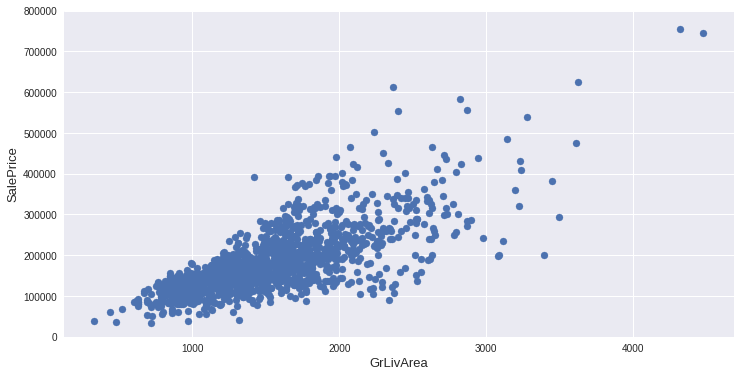

In [11]:
# Graphs after removing outliers
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [12]:
train.shape

(1458, 80)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   object 
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   object 
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   int64  
 18  YearBuil

In [14]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1458.000000,1199.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1450.000000,1458.000000,1458.000000,...,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,56.893004,69.797331,10459.936900,6.093964,5.576132,1971.218107,1984.834019,102.753793,438.827160,46.613169,...,94.084362,46.245542,21.984225,3.414266,15.081619,2.433471,43.548697,6.323045,2007.816187,180932.919067
std,42.329437,23.203458,9859.198156,1.376369,1.113359,30.193754,20.641760,179.442156,432.969094,161.420729,...,125.350021,65.312932,61.155666,29.337173,55.792877,38.209947,496.460799,2.700167,1.328826,79495.055285
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129925.000000
50%,50.000000,69.000000,9475.000000,6.000000,5.000000,1972.500000,1994.000000,0.000000,382.000000,0.000000,...,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,164.750000,711.000000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2188.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


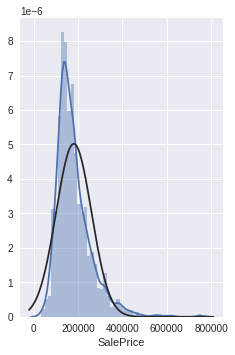

In [15]:
# Checking if the log is required for the housing sales price
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=True, fit = norm)

Text(0.5, 0, 'Log SalePrice')

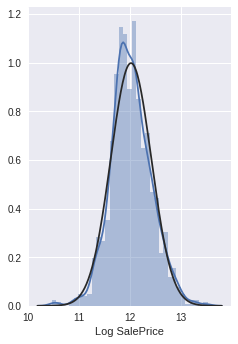

In [16]:
#Plot is right skewed, so we need to normalize this distribution

plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train.SalePrice + 1), kde=True, fit = norm)
plt.xlabel('Log SalePrice')

In [17]:
#Applying log to house price
train.SalePrice = np.log1p(train.SalePrice)

In [18]:
train_y = train.SalePrice.reset_index(drop=True)
train_x = train.drop(['SalePrice'], axis=1)
test_x = test

In [19]:
train_x.shape

(1458, 79)

In [20]:
test_x.shape

(1459, 79)

In [21]:
total_features = pd.concat([train_x, test_x]).reset_index(drop=True)
total_features.shape

(2917, 79)

Determine the missing values

In [22]:
nulls = np.sum(total_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = total_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

Impute the Missing Values

In [23]:
total_features['Functional'] = total_features['Functional'].fillna('Typ')
total_features['Electrical'] = total_features['Electrical'].fillna("SBrkr")
total_features['KitchenQual'] = total_features['KitchenQual'].fillna("TA")

total_features['Exterior1st'] = total_features['Exterior1st'].fillna(total_features['Exterior1st'].mode()[0])
total_features['Exterior2nd'] = total_features['Exterior2nd'].fillna(total_features['Exterior2nd'].mode()[0])

total_features['SaleType'] = total_features['SaleType'].fillna(total_features['SaleType'].mode()[0])

Check what value to impute, when the variable value is missing.

In [24]:
pd.set_option('max_columns', None)
total_features[total_features['PoolArea'] > 0 & total_features['PoolQC'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
809,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1169,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1181,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1384,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,TA,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1421,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1972,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,Ex,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2418,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2571,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8

In [25]:
total_features.loc[2418, 'PoolQC'] = 'Fa'
total_features.loc[2501, 'PoolQC'] = 'Gd'
total_features.loc[2597, 'PoolQC'] = 'Fa'

In [26]:
pd.set_option('max_columns', None)
total_features[(total_features['GarageType'] == 'Detchd') & total_features['GarageYrBlt'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [27]:
total_features.loc[2124, 'GarageYrBlt'] = total_features['GarageYrBlt'].median()
total_features.loc[2574, 'GarageYrBlt'] = total_features['GarageYrBlt'].median()

total_features.loc[2124, 'GarageFinish'] = total_features['GarageFinish'].mode()[0]
total_features.loc[2574, 'GarageFinish'] = total_features['GarageFinish'].mode()[0]

total_features.loc[2574, 'GarageCars'] = total_features['GarageCars'].median()

total_features.loc[2124, 'GarageArea'] = total_features['GarageArea'].median()
total_features.loc[2574, 'GarageArea'] = total_features['GarageArea'].median()

total_features.loc[2124, 'GarageQual'] = total_features['GarageQual'].mode()[0]
total_features.loc[2574, 'GarageQual'] = total_features['GarageQual'].mode()[0]

total_features.loc[2124, 'GarageCond'] = total_features['GarageCond'].mode()[0]
total_features.loc[2574, 'GarageCond'] = total_features['GarageCond'].mode()[0]

In [28]:
# Basement Variables with NA, are now filled

total_features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
total_features.loc[947, 'BsmtExposure'] = 'No' 
total_features.loc[1485, 'BsmtExposure'] = 'No'
total_features.loc[2038, 'BsmtCond'] = 'TA'
total_features.loc[2183, 'BsmtCond'] = 'TA'
total_features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
total_features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
total_features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
total_features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

In [29]:
subclass_group = total_features.groupby('MSSubClass')
Zoning_modes = subclass_group['MSZoning'].apply(lambda x : x.mode()[0])
total_features['MSZoning'] = total_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [30]:
neighborhood_group = total_features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
total_features['LotFrontage'] = total_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [31]:
#Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in total_features.columns:
    if total_features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
total_features.update(total_features[numerics].fillna(0))

# remaining columns 

columns = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", 
         "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", 
         "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]

for col in columns:
    total_features.update(total_features[col].fillna("None", inplace=True))


nulls = np.sum(total_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = total_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

           0       1
Utilities  2  object
There are 1 columns with missing values


In [32]:
total_features = total_features.drop(['Utilities','Street'], axis=1)

In [33]:
#FEATURE ENGINEERING

total_features['Total_sqr_footage'] = (total_features['BsmtFinSF1'] + total_features['BsmtFinSF2'] +
                                 total_features['1stFlrSF'] + total_features['2ndFlrSF'])

total_features['Total_Bathrooms'] = (total_features['FullBath'] + (0.5*total_features['HalfBath']) + 
                               total_features['BsmtFullBath'] + (0.5*total_features['BsmtHalfBath']))

total_features['Total_porch_sf'] = (total_features['OpenPorchSF'] + total_features['3SsnPorch'] +
                              total_features['EnclosedPorch'] + total_features['ScreenPorch'] +
                             total_features['WoodDeckSF'])


#simplified features
total_features['haspool'] = total_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
total_features['has2ndfloor'] = total_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
total_features['hasgarage'] = total_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
total_features['hasbsmt'] = total_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
total_features['hasfireplace'] = total_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [34]:
total_features.shape

(2917, 85)

In [35]:
final_features = pd.get_dummies(total_features).reset_index(drop=True)
final_features.shape

(2917, 306)

In [36]:
final_train_x = final_features.iloc[:len(train_y),:]
final_test_x = final_features.iloc[len(final_train_x):,:] 

In [37]:
final_train_x.shape

(1458, 306)

In [38]:
final_test_x.shape

(1459, 306)

Apply TSNE 

In [39]:
#Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, verbose = 2)
TSNE_X = tsne.fit_transform(final_train_x)
TSNE_X_test = tsne.fit_transform(final_test_x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1458 samples in 0.037s...
[t-SNE] Computed neighbors for 1458 samples in 0.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1458
[t-SNE] Computed conditional probabilities for sample 1458 / 1458
[t-SNE] Mean sigma: 299.604414
[t-SNE] Computed conditional probabilities in 0.142s
[t-SNE] Iteration 50: error = 68.6806183, gradient norm = 0.1601083 (50 iterations in 0.499s)
[t-SNE] Iteration 100: error = 64.8066864, gradient norm = 0.0582299 (50 iterations in 0.349s)
[t-SNE] Iteration 150: error = 64.2376099, gradient norm = 0.0476874 (50 iterations in 0.365s)
[t-SNE] Iteration 200: error = 64.0848923, gradient norm = 0.0436690 (50 iterations in 0.350s)
[t-SNE] Iteration 250: error = 64.0105896, gradient norm = 0.0408548 (50 iterations in 0.528s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.010590
[t-SNE] Iteration 300: error = 0.8873256, gradient norm = 0.0008107 (50 iterations in 0.337

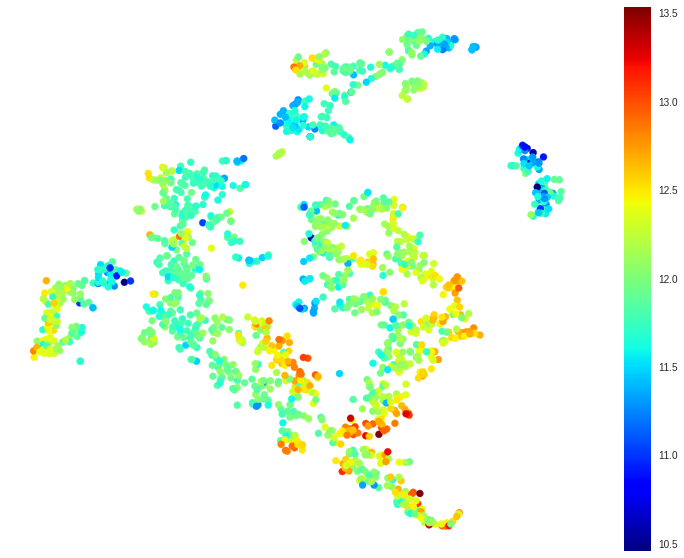

In [40]:
plt.figure(figsize=(13,10))
plt.scatter(TSNE_X[:, 0], TSNE_X[:, 1], c=train_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

PCA - Not better than TSNE

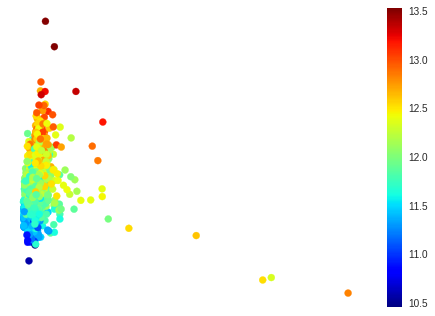

In [41]:
from sklearn.decomposition import PCA

PCA_train_x = PCA(n_components=300, random_state=42).fit_transform(final_train_x)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=train_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Kernel PCA

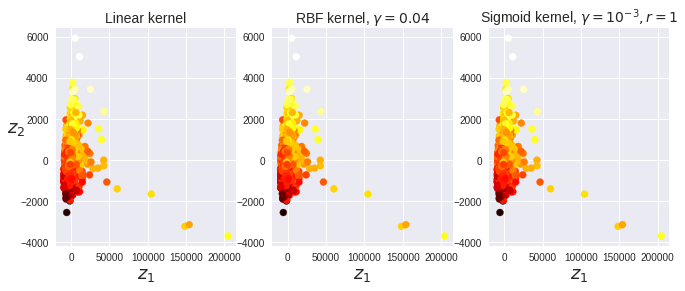

In [42]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=train_y, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Locally Linear Embedding

In [43]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
PCA_X = lle.fit_transform(final_train_x)

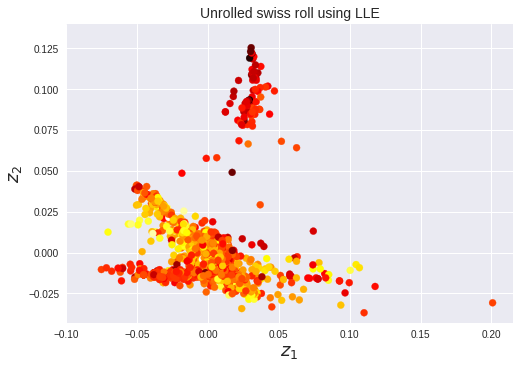

In [44]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(PCA_X [:, 0], PCA_X [:, 1], c= train_y, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.100, 0.215, -0.043, 0.14])
plt.grid(True)
plt.show()

PCA + TSNE

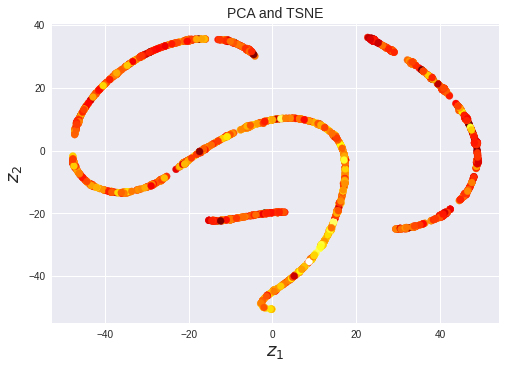

In [45]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])
X_pca_tsne = pca_tsne.fit_transform(final_train_x)
plt.title("PCA and TSNE", fontsize=14)
plt.scatter(X_pca_tsne [:, 0], X_pca_tsne [:, 1], c= train_y, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.show()

None of the above techniques could clearly identify the clusters. So I will drop the idea of dropping any dimensions

Now We Build the Models

In [46]:
#Random Forest Regressor.
forest_class = RandomForestRegressor(random_state = 42)

n_estimators = [10,70,500,700]
max_features = ["auto",'sqrt','log2']

param_grid_forest = {'n_estimators' : n_estimators, 'max_features' : max_features}

rand_search_forest = RandomizedSearchCV(forest_class, param_grid_forest, cv = 4, 
                                        scoring='neg_mean_squared_error', n_jobs = -1, verbose=2)

rand_search_forest.fit(final_train_x, train_y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   57.6s finished


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 70, 500, 700]},
                   scoring='neg_mean_squared_error', verbose=2)

In [47]:
random_estimator = rand_search_forest.best_estimator_ 
y_pred_rf= random_estimator.predict(final_train_x)
rf_msle = mean_squared_error(train_y, y_pred_rf)
rf_rmsle = np.sqrt(rf_msle)
rf_rmsle

0.05010412034866873

In [48]:
GB_Regressor = GradientBoostingRegressor(random_state = 42)

n_estimators = [50,500]

param_grid_grad_boost_class = {'n_estimators' : n_estimators}

rand_search_grad_boost_class = GridSearchCV(GB_Regressor, param_grid_grad_boost_class, cv = 4, scoring='neg_mean_squared_error', 
                               refit = True, n_jobs = -1, verbose = 2)

rand_search_grad_boost_class.fit(final_train_x, train_y)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    8.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.9s finished


GridSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [50, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [49]:
gb_estimator = rand_search_grad_boost_class.best_estimator_ 
y_pred_gb= gb_estimator.predict(final_train_x)
gb_msle = mean_squared_error(train_y, y_pred_gb)
gb_rmsle = np.sqrt(gb_msle)
gb_rmsle

0.037503938027834825

In [50]:
en = ElasticNet()
en.fit(final_train_x, train_y)

ElasticNet()

In [51]:
#Implement an Elastic Net regressor

ElasticRegressor = ElasticNet()

alpha = [.0001,.0005,.005,.05,1]

param_grid_elastic = {'alpha' : alpha}

rand_search_elastic = GridSearchCV(ElasticRegressor, param_grid_elastic, cv = 4, scoring='neg_mean_squared_error', 
                               refit = True, n_jobs = -1, verbose = 2)

rand_search_elastic.fit(final_train_x, train_y)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.2s finished


GridSearchCV(cv=4, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.005, 0.05, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [52]:
elastic_estimator = rand_search_elastic.best_estimator_
y_pred_elastic = elastic_estimator.predict(final_train_x)
elastic_msle = mean_squared_error(train_y, y_pred_elastic)
elastic_rmsle = np.sqrt(elastic_msle)
elastic_rmsle

0.0969119890893796

In [53]:
#Implement a lasso regresso

LassoRegressor = LassoCV()

max_iter = [50,100,500,1000]

param_grid_lasso = {'max_iter' : max_iter}

rand_search_lasso = GridSearchCV(LassoRegressor, param_grid_lasso, cv = 4, scoring='neg_mean_squared_error', 
                               refit = True, n_jobs = -1, verbose = 2)

rand_search_lasso.fit(final_train_x, train_y)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.4s finished


GridSearchCV(cv=4, estimator=LassoCV(), n_jobs=-1,
             param_grid={'max_iter': [50, 100, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [54]:
lasso_estimator = rand_search_lasso.best_estimator_
y_pred_lasso= lasso_estimator.predict(final_train_x)
lasso_msle = mean_squared_error(train_y, y_pred_lasso)
lasso_rmsle = np.sqrt(lasso_msle)
lasso_rmsle

0.1651502165004421

In [55]:
xgb = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb.fit(final_train_x, train_y)

[13:41:13] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:29] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
y_pred_xgb= xgb_fit.predict(final_train_x)
xgb_msle = mean_squared_error(train_y, y_pred_xgb)
xgb_rmsle = np.sqrt(xgb_msle)
xgb_rmsle

0.048736011655659

In [57]:
lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgbm_fit = xgb.fit(final_train_x, train_y)

[13:41:30] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:46] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
y_pred_lgbm= lgbm_fit.predict(final_train_x)
lgbm_msle = mean_squared_error(train_y, y_pred_lgbm)
lgbm_rmsle = np.sqrt(lgbm_msle)
lgbm_rmsle

0.048736011655659

Submit the first submission - with Gradient Boosting as best model

In [59]:
y_pred_gb_test= gb_estimator.predict(final_test_x)
y_pred_rf_test= random_estimator.predict(final_test_x)
y_pred_las_test = lasso_estimator.predict(final_test_x)
y_pred_elas_test = elastic_estimator.predict(final_test_x)
y_pred_xgb_test = xgb_fit.predict(final_test_x)
y_pred_lgbm_test = lgbm_fit.predict(final_test_x)

Taking the averages of best 4 models - Gradient Boosting, Light GBM, XG Boost and Random Forest. This will be improved with Stacking Regressor in the next version.

In [60]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(y_pred_gb_test) + np.expm1(y_pred_rf_test) + np.expm1(y_pred_xgb_test) + np.expm1(y_pred_lgbm_test))/ 4
submission.to_csv('submission.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/sample_submission.csv'